In [ ]:
# import pickle
import numpy as np
import matplotlib.pyplot as plt
import os, copy


# import time
# import itertools
from matplotlib import image
import glob as glob
from PIL import Image
import cv2
import random
import geopy.distance
# from google.colab import drive
import requests
import json

from tqdm import tqdm
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only. If you want to enable GPU, please to go Edit > Notebook Settings > Hardware Accelerator and select GPU.")


PyTorch Version:  1.13.0+cu117
Torchvision Version:  0.14.0+cu117
Using the GPU!


In [ ]:
# parameters
batch_size = 32
num_workers = 2
head_lr = 1e-3
image_encoder_lr = 1e-4
text_encoder_lr = 1e-5
weight_decay = 1e-3
patience = 1
factor = 0.8
epochs = 40

image_encoder_model = 'vgg16'
image_embedding = 1000 # output channels of VGG-16

# input_size = 227 # input size of VGG-16
input_size = 227

# projection_dim = 256 

num_classifiers = 6 # longtitude (degree, hours, seconds) and latitude (degree, hours, seconds)

train_normal_data_size = 8000

In [ ]:
project_directory="drive/Shareddrives/EECS 504 Project"
dataset_directory="./Street View Dataset"

# drive.mount('/content/drive')
# !unzip "drive/Shareddrives/EECS 504 Project/Street View Dataset.zip" -d "/content"

In [ ]:
from torch.utils.data import IterableDataset
from PIL import UnidentifiedImageError

# Decide if any other transform needed
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((input_size, input_size)),
                                transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),])

class GeoTrainDataset(Dataset):
  def __init__(self, root_dir, split="train_normal", transform=None):
        super().__init__()

        image_paths=[]

        for city_folder in glob.glob(root_dir+"/*"):
          image_paths.append(glob.glob(city_folder+"/*"))
        image_paths = [item for sublist in image_paths for item in sublist]
        
        random.shuffle(image_paths)

        if split=="train_normal":
          image_paths = image_paths[0 : train_normal_data_size]
        
        elif split=="test":
          image_paths = image_paths[train_normal_data_size : len(image_paths)]

        self.files=image_paths
        self.transform = transform

  def __len__(self):
    return len(self.files)

  def __getitem__(self, idx):
      file_name = self.files[idx]

      # get lat, lon of each feature
      lat = file_name.split('_')[0].split('\\')[-1]
      lon = file_name.split('_')[1]

      decimal_coords = torch.tensor([float(lat), float(lon)]).to(device)

      with Image.open(file_name) as img:
        img = np.asarray(img)
        img = self.transform(img)

        return img, decimal_coords

In [ ]:
# inspired from https://ieeexplore-ieee-org.proxy.lib.umich.edu/abstract/document/7539697
def spatial_unstructured_layer(x):
  x_m = x.clone()
  p, q, r, s = x.size()
  block_sizes = [0, 4, 8, 12, 16]
  index = np.random.randint(0, 5)
  number_of_blocks = 2**block_sizes[index]
  l = int(np.floor(np.sqrt(number_of_blocks) / 2))
  h_pts = torch.linspace(0, r, l + 1).long()
  w_pts = h_pts

  for i in range(0, len(h_pts) - 1):
    for j in range(0, len(w_pts) - 1):
      x_tmp = x[:, :, h_pts[i]:h_pts[i+1], w_pts[j]:w_pts[j+1]]
      x_tmp = torch.cat((x_tmp[:, :, int(np.floor(x_tmp.size()[2] / 2)):x_tmp.size()[2], :], x_tmp[:, :, 0:int(np.floor(x_tmp.size()[2] / 2)), :]), dim=2).to(device)
      x_tmp = torch.cat((x_tmp[:, :, :, int(np.floor(x_tmp.size()[3] / 2)):x_tmp.size()[3]], x_tmp[:, :, :, 0:int(np.floor(x_tmp.size()[3] / 2))]), dim=3).to(device)
      x_m[:, :, h_pts[i]:h_pts[i+1], w_pts[j]:w_pts[j+1]] = x_tmp
  
  return x_m

c:\Users\thomas\Documents\UMICH\torch.venv\lib\site-packages\torchvision\transforms\functional.py:149: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ..\torch\csrc\utils\tensor_numpy.cpp:205.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


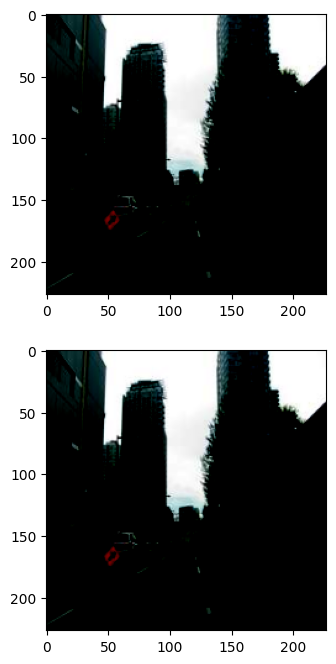

In [ ]:
dummy_x = torch.rand((32, 256, 54, 54))
with Image.open('./Street View Dataset/Vancouver/49.268882666114024_-123.11476707458496_498350904693525.jpg') as img:
        img = np.asarray(img)
        img = transform(img)
        img = torch.unsqueeze(img, dim=0)
x_m = spatial_unstructured_layer(img)
fig, axes = plt.subplots(2, 1,figsize=(15,8))
axes[0].imshow(img[0].numpy().transpose((1, 2, 0)))
axes[1].imshow(x_m[0].numpy().transpose((1, 2, 0)))
plt.show()

In [ ]:
# https://link.springer.com/content/pdf/10.1007/978-3-319-10578-9.pdf?pdf=button
# https://towardsdatascience.com/understanding-sppnet-for-object-detection-and-classification-682d6d2bdfb
def spatial_pyramid_pooling(x, input_size=13):
  output_sizes = [1, 2, 4]
  output = None

  for output_size in output_sizes:
    kernel_size = int(np.ceil(input_size / output_size))
    stride_size = int(np.floor(input_size / output_size))
    pool = nn.MaxPool2d(kernel_size=(kernel_size, kernel_size), stride=stride_size)
    x_curr = pool(x)
    x_curr = torch.flatten(x_curr,1)

    if output == None:
      output = x_curr
    else:
      output = torch.cat((output, x_curr), dim=1)
  
  return output


In [ ]:
class GeoClassifier(nn.Module):
    def __init__(
        self,
    ):
        super().__init__()
        '''
        Args:
        '''
        
        # AlexNet-VGG-16-BN architecture
        self.alex_net_inspired = nn.Sequential(nn.Conv2d(3, 96, 11, 1, 1),
                                       nn.ReLU(),
                                       nn.MaxPool2d(3, 2),
                                       nn.Conv2d(96, 256, 5, 1, 2),
                                       nn.ReLU(),
                                       nn.MaxPool2d(3, 2),
                                       nn.Conv2d(256, 384, 3, 1, 1),
                                       nn.ReLU(),
                                       nn.Conv2d(384, 384, 3, 1, 1),
                                       nn.ReLU(),
                                       nn.Conv2d(384, 256, 3, 1, 1),
                                       nn.ReLU(),
                                       nn.MaxPool2d(3, 2))  # end of AlexNet

        self.vgg16_inspired = nn.Sequential(nn.Conv2d(256, 256, 3, 1, 1), # start part of VGG-16
                                       nn.BatchNorm2d(256, eps=1e-05, momentum=0.1),
                                       nn.ReLU(),
                                       nn.Conv2d(256, 256, 3, 1, 1), 
                                       nn.BatchNorm2d(256, eps=1e-05, momentum=0.1),
                                       nn.ReLU(),
                                       nn.MaxPool2d(2, 2),
                                       nn.Conv2d(256, 256, 3, 1, 1), 
                                       nn.BatchNorm2d(256, eps=1e-05, momentum=0.1),
                                       nn.ReLU(),
                                       nn.Conv2d(256, 256, 3, 1, 1), 
                                       nn.BatchNorm2d(256, eps=1e-05, momentum=0.1),
                                       nn.ReLU()) # remove nn.MaxPool2d(2, 2), since we will apply spatial_pyramid_pooling
        
        self.relu = nn.ReLU()
        self.dense = nn.Linear(5376, 100) # 256*4*4 + 256*2*2 + 256*1*1 = 10752
        self.dense1 = nn.Linear(100, 100) #reduced from 4096
        self.dense2 = nn.Linear(100, 2)
    def forward(self, x):
        '''
        Args:
            x: Image batch

        Return:
            projected: Coordinate predictions
        '''

        
        x = self.alex_net_inspired(x)
        x = spatial_unstructured_layer(x)
        x = self.vgg16_inspired(x)
        # x = torch.flatten(x,1)
        x = spatial_pyramid_pooling(x)
        
        x = self.relu(self.dense(x))
        x = self.relu(self.dense1(x))
        out = self.dense2(x)

        return out

In [ ]:
model = GeoClassifier().to(device)
summary(model, (3, 227, 227))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 96, 219, 219]          34,944
              ReLU-2         [-1, 96, 219, 219]               0
         MaxPool2d-3         [-1, 96, 109, 109]               0
            Conv2d-4        [-1, 256, 109, 109]         614,656
              ReLU-5        [-1, 256, 109, 109]               0
         MaxPool2d-6          [-1, 256, 54, 54]               0
            Conv2d-7          [-1, 384, 54, 54]         885,120
              ReLU-8          [-1, 384, 54, 54]               0
            Conv2d-9          [-1, 384, 54, 54]       1,327,488
             ReLU-10          [-1, 384, 54, 54]               0
           Conv2d-11          [-1, 256, 54, 54]         884,992
             ReLU-12          [-1, 256, 54, 54]               0
        MaxPool2d-13          [-1, 256, 26, 26]               0
           Conv2d-14          [-1, 256,

In [ ]:
def get_batch_distances(inputs,targets):
    dist_list =[]
    length=inputs.size()[0]
    for i in range(length):
        ins=inputs.cpu().detach().numpy()[i]
        tar=targets.cpu().detach().numpy()[i]
        try:
            dist_list.append(geopy.distance.geodesic(ins,tar).km) #distance between two lat,lon pairs in km
        except:
            dist_list.append(20000) #if coordinates are out of bounds, return maximum error (half earth circumference = 20,000km)
    return torch.tensor(dist_list)
    

In [ ]:
def get_geoguessr_score(input,target):
    a= 5000
    b=0.998
    x=geopy.distance.geodesic(input,target).km
    score = a*b**x
    return score


In [ ]:
def train_model(model, dataloaders, save_dir = None, num_epochs=20):
    """
    Args:
        model: The NN to train
        dataloaders: A dictionary containing at least the keys 
                    'train','val' that maps to Pytorch data loaders for the dataset
        criterion: The Loss function
        optimizer: Pytroch optimizer. The algorithm to update weights 
        num_epochs: How many epochs to train for
        save_dir: Where to save the best model weights that are found. Using None will not write anything to disk.

    Returns:
        model: The trained NN
        tr_acc_history: list, training accuracy history. Recording freq: one epoch.
        val_acc_history: list, validation accuracy history. Recording freq: one epoch.
    """

    val_acc_history = []
    tr_acc_history = []
    optimizer=optim.Adam(model.parameters(),betas=(0.9,0.999),lr=0.008)
    criterion = nn.MSELoss().cuda()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 12000.0
    a=0.9 # logrithmic weight (higher means stronger tempering)
    b=200 # regularizing parameter
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            # loss and number of correct prediction for the current batch
            running_loss = 0.0
            distance = 0
            running_hits=0

            # Iterate over data.
            # TQDM has nice progress bars
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                
                optimizer.zero_grad()
                
                outputs=model(inputs)
                #outputs = F.tanh(outputs)
                # outputs[:,0]=outputs[:,0]*180-90
                # outputs[:,1]=outputs[:,1]*360-180
                # loss=criterion(outputs,labels)
                # loss=torch.sqrt(criterion(torch.log(outputs.add(1)),torch.log(labels.add(1))))
                
                x=criterion(outputs, labels)
                loss=20*b*a*torch.log(x/b + 1)+(1-a)*x #experimental loss function. Tuned for more desireable function shape
                
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                

                # statistics
                running_loss += loss.item() * inputs.size(0)
                distance += torch.sum(get_batch_distances(outputs,labels))
                running_hits += torch.sum(get_batch_distances(outputs,labels)<=100)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = distance.double() / len(dataloaders[phase].dataset)
            epoch_hits = running_hits/len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: <{:.4f} km Hits: {:.4f}'.format(phase, epoch_loss, epoch_acc,epoch_hits))

            # deep copy the model
            if phase == 'val' and epoch_acc < best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

                # save the best model weights
                # =========================================================== #
                # IMPORTANT:
                # Losing your connection to colab will lead to loss of trained 
                # weights.
                # You should download the trained weights to your local machine. 
                # Later, you can load these weights directly without needing to 
                # train the neural networks again.
                # =========================================================== #
                if save_dir:
                    torch.save(best_model_wts, os.path.join(save_dir, "GeoCNN" + '.pth'))

            # record the train/val accuracies
            if phase == 'val':
                val_acc_history.append(epoch_acc)
            else:
                tr_acc_history.append(epoch_acc)
                
    print('Best val Acc: {:4f}'.format(best_acc))

    return model, tr_acc_history, val_acc_history

In [ ]:
model.load_state_dict(torch.load('./GeoCNN.pth')) #if loading model, otherwise comment out


<All keys matched successfully>

In [ ]:

print('Model parameters:', sum(p.numel() for p in model.parameters()))
# train 
train_dataset = GeoTrainDataset(root_dir = dataset_directory, split = "train_normal", transform = transform)
print('Number of images train {}'.format(len(train_dataset)))
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# test
test_dataset = GeoTrainDataset(root_dir = dataset_directory, split = "test", transform = transform)
print('Number of images test {}'.format(len(test_dataset)))
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
dataloaders =  {
    'train': train_dataloader,
    'val' : test_dataloader
    }

model, tr_acc_history, val_acc_history = train_model(model,dataloaders, save_dir="./",num_epochs=epochs)

torch.save(model.state_dict(), "./train_normal.pth")



Model parameters: 6657570
Number of images train 8000
Number of images test 1478
Epoch 0/39
----------


100%|██████████| 250/250 [11:32<00:00,  2.77s/it]


train Loss: 6881.0890 Acc: <4122.8848 km Hits: 0.0006


100%|██████████| 47/47 [03:49<00:00,  4.88s/it]


val Loss: 6528.2981 Acc: <3959.4672 km Hits: 0.0020
Epoch 1/39
----------


100%|██████████| 250/250 [29:24<00:00,  7.06s/it]   


train Loss: 6735.4435 Acc: <4051.7667 km Hits: 0.0008


100%|██████████| 47/47 [00:29<00:00,  1.58it/s]


val Loss: 6246.1246 Acc: <3812.3657 km Hits: 0.0000
Epoch 2/39
----------


100%|██████████| 250/250 [15:40<00:00,  3.76s/it]


train Loss: 6320.3673 Acc: <3803.3260 km Hits: 0.0006


100%|██████████| 47/47 [00:37<00:00,  1.24it/s]


val Loss: 6530.0681 Acc: <3837.1519 km Hits: 0.0007
Epoch 3/39
----------


100%|██████████| 250/250 [12:09<00:00,  2.92s/it]


train Loss: 6331.5473 Acc: <3825.7690 km Hits: 0.0005


100%|██████████| 47/47 [00:31<00:00,  1.48it/s]


val Loss: 6375.5893 Acc: <3848.9056 km Hits: 0.0014
Epoch 4/39
----------


100%|██████████| 250/250 [12:26<00:00,  2.98s/it]


train Loss: 6398.0939 Acc: <3855.5775 km Hits: 0.0009


100%|██████████| 47/47 [00:39<00:00,  1.19it/s]


val Loss: 6213.3245 Acc: <3790.1150 km Hits: 0.0007
Epoch 5/39
----------


100%|██████████| 250/250 [11:51<00:00,  2.85s/it]


train Loss: 6247.8168 Acc: <3775.6600 km Hits: 0.0012


100%|██████████| 47/47 [00:46<00:00,  1.00it/s]


val Loss: 6242.7349 Acc: <3786.2585 km Hits: 0.0007
Epoch 6/39
----------


100%|██████████| 250/250 [12:28<00:00,  2.99s/it]


train Loss: 6320.5385 Acc: <3810.9260 km Hits: 0.0003


100%|██████████| 47/47 [00:31<00:00,  1.50it/s]


val Loss: 6380.6413 Acc: <3820.1560 km Hits: 0.0000
Epoch 7/39
----------


100%|██████████| 250/250 [12:55<00:00,  3.10s/it]


train Loss: 6065.6115 Acc: <3679.9410 km Hits: 0.0009


100%|██████████| 47/47 [00:34<00:00,  1.38it/s]


val Loss: 6378.2123 Acc: <3828.8745 km Hits: 0.0000
Epoch 8/39
----------


100%|██████████| 250/250 [10:27<00:00,  2.51s/it]


train Loss: 6212.9000 Acc: <3729.3882 km Hits: 0.0009


100%|██████████| 47/47 [00:35<00:00,  1.31it/s]


val Loss: 6512.5393 Acc: <3917.7388 km Hits: 0.0000
Epoch 9/39
----------


100%|██████████| 250/250 [17:05<00:00,  4.10s/it]


train Loss: 5973.3978 Acc: <3621.6833 km Hits: 0.0006


100%|██████████| 47/47 [00:36<00:00,  1.29it/s]


val Loss: 6510.4283 Acc: <3957.0044 km Hits: 0.0007
Epoch 10/39
----------


100%|██████████| 250/250 [14:07<00:00,  3.39s/it]


train Loss: 5885.0768 Acc: <3557.3122 km Hits: 0.0010


100%|██████████| 47/47 [00:33<00:00,  1.39it/s]


val Loss: 6901.2575 Acc: <4217.3512 km Hits: 0.0020
Epoch 11/39
----------


 11%|█         | 27/250 [02:22<21:57,  5.91s/it]c:\Users\thomas\Documents\UMICH\torch.venv\lib\site-packages\geopy\point.py:472: UserWarning: Latitude normalization has been prohibited in the newer versions of geopy, because the normalized value happened to be on a different pole, which is probably not what was meant. If you pass coordinates as positional args, please make sure that the order is (latitude, longitude) or (y, x) in Cartesian terms.
  return cls(*args)
100%|██████████| 250/250 [13:14<00:00,  3.18s/it]


train Loss: 5998.5445 Acc: <3620.1340 km Hits: 0.0008


100%|██████████| 47/47 [00:37<00:00,  1.27it/s]


val Loss: 6012.9628 Acc: <3598.6922 km Hits: 0.0000
Epoch 12/39
----------


100%|██████████| 250/250 [13:53<00:00,  3.33s/it]


train Loss: 5699.4820 Acc: <3451.2000 km Hits: 0.0010


100%|██████████| 47/47 [00:29<00:00,  1.60it/s]


val Loss: 6102.0525 Acc: <3636.7020 km Hits: 0.0007
Epoch 13/39
----------


100%|██████████| 250/250 [15:01<00:00,  3.61s/it]


train Loss: 5740.5387 Acc: <3470.7578 km Hits: 0.0015


100%|██████████| 47/47 [00:33<00:00,  1.38it/s]


val Loss: 6066.1114 Acc: <3624.2537 km Hits: 0.0000
Epoch 14/39
----------


100%|██████████| 250/250 [12:49<00:00,  3.08s/it]


train Loss: 5464.6862 Acc: <3307.7922 km Hits: 0.0010


100%|██████████| 47/47 [00:26<00:00,  1.75it/s]


val Loss: 5906.2298 Acc: <3570.3664 km Hits: 0.0007
Epoch 15/39
----------


100%|██████████| 250/250 [13:28<00:00,  3.23s/it]


train Loss: 5532.2087 Acc: <3339.5682 km Hits: 0.0018


100%|██████████| 47/47 [00:33<00:00,  1.41it/s]


val Loss: 6850.5855 Acc: <4082.9885 km Hits: 0.0014
Epoch 16/39
----------


100%|██████████| 250/250 [13:44<00:00,  3.30s/it]


train Loss: 5557.7853 Acc: <3355.0673 km Hits: 0.0011


100%|██████████| 47/47 [00:41<00:00,  1.12it/s]


val Loss: 6189.7732 Acc: <3584.5809 km Hits: 0.0014
Epoch 17/39
----------


100%|██████████| 250/250 [11:26<00:00,  2.74s/it]


train Loss: 5440.7957 Acc: <3298.9198 km Hits: 0.0004


100%|██████████| 47/47 [00:31<00:00,  1.51it/s]


val Loss: 6350.9333 Acc: <3820.2747 km Hits: 0.0034
Epoch 18/39
----------


100%|██████████| 250/250 [11:59<00:00,  2.88s/it]


train Loss: 5499.6920 Acc: <3347.1683 km Hits: 0.0018


100%|██████████| 47/47 [00:38<00:00,  1.23it/s]


val Loss: 6189.6113 Acc: <3631.2774 km Hits: 0.0020
Epoch 19/39
----------


100%|██████████| 250/250 [10:46<00:00,  2.59s/it]


train Loss: 5401.3240 Acc: <3284.4758 km Hits: 0.0009


100%|██████████| 47/47 [00:34<00:00,  1.38it/s]


val Loss: 5915.1594 Acc: <3462.6820 km Hits: 0.0020
Epoch 20/39
----------


100%|██████████| 250/250 [14:12<00:00,  3.41s/it]


train Loss: 5173.1137 Acc: <3137.2185 km Hits: 0.0006


100%|██████████| 47/47 [00:32<00:00,  1.46it/s]


val Loss: 6119.8044 Acc: <3646.2256 km Hits: 0.0014
Epoch 21/39
----------


100%|██████████| 250/250 [12:58<00:00,  3.12s/it]


train Loss: 5207.1035 Acc: <3169.4788 km Hits: 0.0009


100%|██████████| 47/47 [00:36<00:00,  1.29it/s]


val Loss: 5872.2680 Acc: <3434.0091 km Hits: 0.0014
Epoch 22/39
----------


100%|██████████| 250/250 [14:44<00:00,  3.54s/it]


train Loss: 5101.2926 Acc: <3095.4972 km Hits: 0.0014


100%|██████████| 47/47 [00:38<00:00,  1.23it/s]


val Loss: 6566.5518 Acc: <3877.6411 km Hits: 0.0007
Epoch 23/39
----------


100%|██████████| 250/250 [11:18<00:00,  2.72s/it]


train Loss: 5170.0059 Acc: <3147.6312 km Hits: 0.0008


100%|██████████| 47/47 [00:34<00:00,  1.37it/s]


val Loss: 5812.5003 Acc: <3415.5051 km Hits: 0.0007
Epoch 24/39
----------


100%|██████████| 250/250 [13:55<00:00,  3.34s/it]


train Loss: 5075.7534 Acc: <3074.1110 km Hits: 0.0014


100%|██████████| 47/47 [00:39<00:00,  1.20it/s]


val Loss: 5582.5728 Acc: <3244.6749 km Hits: 0.0014
Epoch 25/39
----------


100%|██████████| 250/250 [14:07<00:00,  3.39s/it]


train Loss: 4976.3923 Acc: <3040.6265 km Hits: 0.0015


100%|██████████| 47/47 [00:48<00:00,  1.02s/it]


val Loss: 5813.9027 Acc: <3424.7889 km Hits: 0.0027
Epoch 26/39
----------


100%|██████████| 250/250 [12:19<00:00,  2.96s/it]


train Loss: 4960.1291 Acc: <3019.6433 km Hits: 0.0012


100%|██████████| 47/47 [00:41<00:00,  1.14it/s]


val Loss: 5767.0034 Acc: <3433.1766 km Hits: 0.0007
Epoch 27/39
----------


100%|██████████| 250/250 [11:17<00:00,  2.71s/it]


train Loss: 5093.7102 Acc: <3090.3025 km Hits: 0.0016


100%|██████████| 47/47 [00:33<00:00,  1.39it/s]


val Loss: 6001.5194 Acc: <3531.6329 km Hits: 0.0020
Epoch 28/39
----------


100%|██████████| 250/250 [13:29<00:00,  3.24s/it]


train Loss: 4929.9665 Acc: <2993.0575 km Hits: 0.0019


100%|██████████| 47/47 [00:29<00:00,  1.61it/s]


val Loss: 5532.8740 Acc: <3230.7659 km Hits: 0.0034
Epoch 29/39
----------


100%|██████████| 250/250 [13:16<00:00,  3.19s/it]


train Loss: 4848.6974 Acc: <2936.5257 km Hits: 0.0012


100%|██████████| 47/47 [00:44<00:00,  1.07it/s]


val Loss: 5604.6885 Acc: <3151.2821 km Hits: 0.0027
Epoch 30/39
----------


100%|██████████| 250/250 [11:46<00:00,  2.83s/it]


train Loss: 5031.3918 Acc: <3043.8972 km Hits: 0.0008


100%|██████████| 47/47 [00:31<00:00,  1.47it/s]


val Loss: 6118.3027 Acc: <3504.7050 km Hits: 0.0007
Epoch 31/39
----------


100%|██████████| 250/250 [12:43<00:00,  3.05s/it]


train Loss: 4622.7705 Acc: <2827.8755 km Hits: 0.0014


100%|██████████| 47/47 [00:29<00:00,  1.59it/s]


val Loss: 5325.3047 Acc: <3123.2903 km Hits: 0.0027
Epoch 32/39
----------


100%|██████████| 250/250 [11:45<00:00,  2.82s/it]


train Loss: 4717.9757 Acc: <2880.2045 km Hits: 0.0012


100%|██████████| 47/47 [00:26<00:00,  1.77it/s]


val Loss: 5878.0925 Acc: <3476.3589 km Hits: 0.0000
Epoch 33/39
----------


100%|██████████| 250/250 [13:06<00:00,  3.15s/it]


train Loss: 4627.2041 Acc: <2827.3955 km Hits: 0.0012


100%|██████████| 47/47 [00:22<00:00,  2.11it/s]


val Loss: 5489.7253 Acc: <3168.7889 km Hits: 0.0007
Epoch 34/39
----------


100%|██████████| 250/250 [13:14<00:00,  3.18s/it]


train Loss: 4647.6398 Acc: <2858.9590 km Hits: 0.0015


100%|██████████| 47/47 [00:52<00:00,  1.12s/it]


val Loss: 5669.2494 Acc: <3337.7737 km Hits: 0.0020
Epoch 35/39
----------


100%|██████████| 250/250 [15:28<00:00,  3.71s/it]


train Loss: 4678.4022 Acc: <2857.9318 km Hits: 0.0012


100%|██████████| 47/47 [00:24<00:00,  1.94it/s]


val Loss: 5586.0587 Acc: <3216.4232 km Hits: 0.0000
Epoch 36/39
----------


100%|██████████| 250/250 [13:00<00:00,  3.12s/it]


train Loss: 4600.7930 Acc: <2845.2823 km Hits: 0.0012


100%|██████████| 47/47 [00:42<00:00,  1.09it/s]


val Loss: 5264.7100 Acc: <3003.2832 km Hits: 0.0014
Epoch 37/39
----------


100%|██████████| 250/250 [13:47<00:00,  3.31s/it]


train Loss: 4331.7481 Acc: <2678.3972 km Hits: 0.0015


100%|██████████| 47/47 [00:37<00:00,  1.27it/s]


val Loss: 5114.3423 Acc: <2991.2930 km Hits: 0.0007
Epoch 38/39
----------


100%|██████████| 250/250 [15:29<00:00,  3.72s/it]


train Loss: 4349.7512 Acc: <2687.7080 km Hits: 0.0016


100%|██████████| 47/47 [00:41<00:00,  1.14it/s]


val Loss: 5476.8229 Acc: <3131.3928 km Hits: 0.0007
Epoch 39/39
----------


100%|██████████| 250/250 [14:22<00:00,  3.45s/it]


train Loss: 4489.3467 Acc: <2752.2790 km Hits: 0.0010


100%|██████████| 47/47 [00:21<00:00,  2.18it/s]

val Loss: 5718.9220 Acc: <3248.5274 km Hits: 0.0007
Best val Acc: 2991.292963


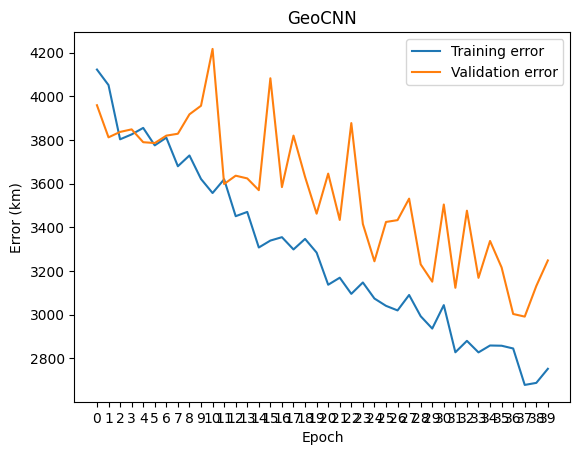

In [ ]:
x = np.arange(epochs)
# train/val accuracies for MiniVGG
plt.figure()
plt.plot(x, torch.tensor(tr_acc_history, device = 'cpu'))
plt.plot(x, torch.tensor(val_acc_history, device = 'cpu'))
plt.legend(['Training error', 'Validation error'])
plt.xticks(x)
plt.xlabel('Epoch')
plt.ylabel('Error (km)')
plt.title('GeoCNN')
plt.show()




In [ ]:
def getGeoClassifierPredictions(img, model):
  img = img.to(device)
  outs = model(img)

  return outs

In [ ]:

score=0
for j in range (10):
    score=0
    for i in range(5):
        tests,coords = test_dataset.__getitem__(i+5*j)
        result = getGeoClassifierPredictions(tests.unsqueeze(dim=0), model)
        score+=get_geoguessr_score(result,coords)
        # print(result)
        # print(coords)
        #print()
    print("geogussr score = {}".format(score))

geogussr score = 3908.000508898007
geogussr score = 347.04676896272883
geogussr score = 548.4771247951555
geogussr score = 887.734305606062
geogussr score = 2063.0506577610167
geogussr score = 2459.422735206981
geogussr score = 398.44534598220633
geogussr score = 2857.559063911387
geogussr score = 140.60310613852982
geogussr score = 2996.7562191663574
